# Example 1: What price should I sell my used iphone for?
* This exmaple is taken from  http://www.statsathome.com/2017/10/12/bayesian-decision-theory-made-ridiculously-simple/

### Task
* Decide for price for a phone from 2014 without scratches

### Todo:
* Excurs to shared variables in pymc3
* Make contour plots and refine the problem

In [10]:
import pandas as pd
from wand.image import Image as wimage
import numpy as np
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import rc
from functools import partial
from scipy.special import expit
from scipy.optimize import minimize_scalar
import pymc3 as pm
import daft
%qtconsole --colors=linux  
%load_ext watermark
%matplotlib inline
%watermark -dmvgp numpy,pandas,matplotlib,daft
plt.rcParams['figure.figsize'] = 14, 8
rc("font", family="serif", size=12)
rc("text", usetex=False)

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2018-07-06 

CPython 3.6.5
IPython 6.2.1

numpy 1.14.2
pandas 0.22.0
matplotlib 2.1.0
daft 0.0.4

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-24-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 7f8c68d60e912e23cac1a81c29d094a4cffa4805


Exception ignored in: <bound method Resource.__del__ of <wand.image.Image: (closed)>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wand/resource.py", line 232, in __del__
    self.destroy()
  File "/usr/local/lib/python3.6/dist-packages/wand/image.py", line 2767, in destroy
    for i in range(0, len(self.sequence)):
TypeError: object of type 'NoneType' has no len()


In [2]:
train = pd.DataFrame({"sold": [1, 1, 0, 0, 1, 1], 
                     "scratched": [0, 0, 1, 0, 0, 0], 
                     "year": [2014, 2015, 2010, 2014, 2015, 2016],
                     "price": [50, 70, 40, 100, 90, 100]})
train

,price,scratched,sold,year
0,50,0,1,2014
1,70,0,1,2015
2,40,1,0,2010
3,100,0,0,2014
4,90,0,1,2015
5,100,0,1,2016


### The model
$$
\begin{align}
y_{\text{sold}, i} &\sim \text{Bernoulli}(\pi_i) \\
\pi_i &\sim \text{logit}^{-1}(\eta_i) \\
\eta_i &\sim \beta_0 + \beta_1 \text{scratched}_i + \beta_2 \text{year_i} + \beta_3 \text{price}_i
\end{align}
$$

### Priors
$$
\begin{align}
\beta_0 &\sim \text{Uniform} \\ 
\beta_1 &\sim \mathcal N(-1, 1) \\
\beta_2 &\sim \mathcal N(1, 1) \\
\beta_3 &\sim \mathcal N(-2, 1) 
\end{align}
$$


### Utility function
* We need to decide at what price we would like to sell the phone
* So the price is our decision space
* $$U(price, \pi) = price \, \pi$$

### Expected utility function
$$ U(price) = \left \langle U(price, \pi)  \right \rangle _ {p(\pi)}$$




### Influence diagram
An alternative, more elegant way is to look at the associated influence Diagram (see Barber, Barber Baysian Reasoning and Machine Learning)
First, we set up the influence diagram:

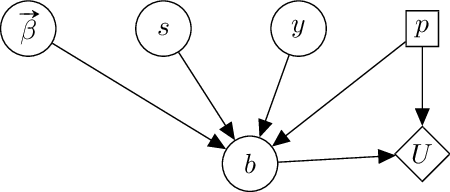

In [13]:
wimage(filename="./pics/influence_diagram_price.pdf", resolution=200)

Where,
* the decision (represented by a square box) is on the price
* the utility function $U$ is represented by the diamond
* the circles represent random variables ($b$ is the random variable "bought")

In order to solve this influence diagram we need to set up the partial ordering 
$$s,y \prec p \prec b, \beta_i, i=0,\dots,3$$
Hence, the variables "scratched" and "year" are known prior the decision (it would be better to indicate them as evidential stats in the influence diagram). $b$ ("bought") is not known prior the decision and the $\beta_i$ are latent variables and also not known prior (even after) the decision.

The expected Utility function is the given by (Eq. 7.3.1 in the Barber Book)
$$U(p ~| ~ s, y) = p(y) p(s) \int \beta \sum_b p(b~|~s,y,p,\beta) p(\beta) U(b,p)$$

The optimal decision is the obtained by _maximising_ the utility function (for a given year and scratch status of the mobile phone),
$$argmax_p(U(p~|~s,y))$$

**Remark 1:**
Note that the formular says that we need $p(s)$ and $p(y)$ in order to compute the utility function. However, since we are only interested in the optimal decision these terms don't contribute to finding tha armax over $p$. (again, one should introduce evidential states)


**Remark 2:**
Assume that we want to sell a phone where we don't know from which year it is or wheter or not it is scratched. Think of it as the phone beeing sealed in a box, and you need to sell it.
In this scenario, the partial ordering would read

$$ p \prec s, y b, \beta_i, i=0,\dots,3$$

So, nothing is kown prior to the decision. The associated expected utility function is then given by
$$U(p) =  \int \beta \sum_b \sum_s \sum_y p(y) p(s) p(b~|~s,y,p,\beta) p(\beta) U(b,p)$$

And the optimal decision is obtained by maximising this term. In this scenario we ne


### Next Steps
* Scale variables or reparametrize in order to make MCMC converge
* Instead of year take feature "years old"
* Include interaction terms
* Use GLM syntax

In [5]:
def get_intial_test_values(model: pm.Model):
    for RV in model.basic_RVs:
        print(RV.name, RV.logp(model.test_point))

def inspect_model(trace):
    pm.traceplot(trace)
    print(pm.summary(trace))
    
    

In [3]:
with pm.Model() as logistic:
    Intercept = pm.Uniform("Intercept", -7000, -1000)
    scratched = pm.Normal("scratched", mu=-1, sd=1)
    year = pm.Normal("year", mu=1, sd=1)    
    price = pm.Normal("price", mu=-2, sd=1) 
    pi = pm.math.invlogit(Intercept + scratched * train.scratched + year * train.year + price * train.price)
    likelihood = pm.Bernoulli('likelihood', pi, observed=train.sold)
    trace_logistic = pm.sample(chains=1, tune=1000, samples=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [price, year, scratched, Intercept_interval__]
100%|██████████| 1500/1500 [04:11<00:00,  5.96it/s]
The acceptance probability does not match the target. It is 0.6904926094244614, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


                  mean          sd   mc_error      hpd_2.5     hpd_97.5
scratched    -0.866720    0.936642   0.090277    -2.995154     0.509974
year          2.400663    0.496356   0.047099     1.391985     3.253500
price        -0.114275    0.075689   0.007274    -0.243224     0.027208
Intercept -4824.774815  999.245965  94.822613 -6533.695656 -2795.365834


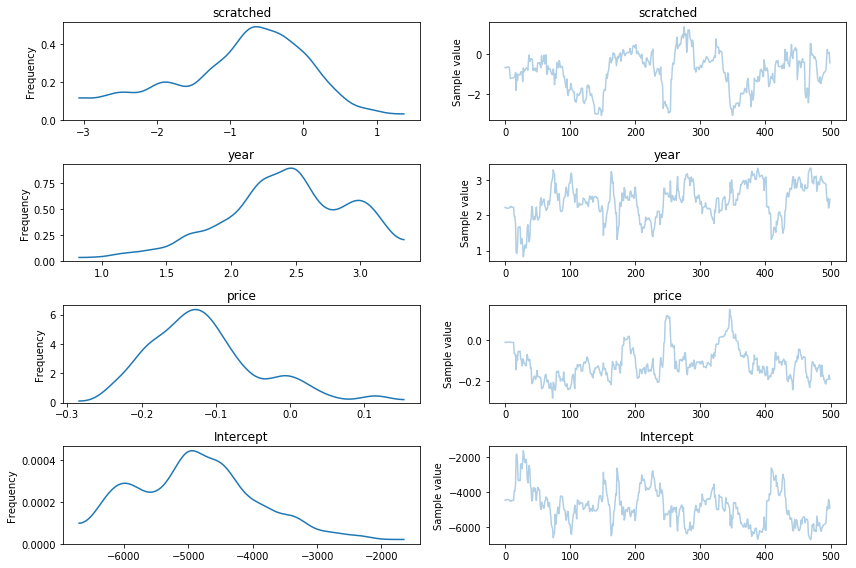

In [6]:
inspect_model(trace_logistic)

In [7]:
def predict(price, scratched, year, trace):
    linear = trace['Intercept'] + trace['scratched'] * scratched + trace['year'] * year + trace['price'] * price
    return expit(linear)

# probabilities for given phone
buy_probability = partial(predict, trace=trace_logistic, scratched=0, year=2014)

# expected utility function
expected_utility = lambda price: price.flatten() * buy_probability(price).mean(axis=1)

# Numerical optimum
optimum = minimize_scalar(lambda x: -expected_utility(np.array([[x]])).flatten()[0])['x']

** First we habe a quick look at the pdf relevant pdf

Text(0.5,0,'price')

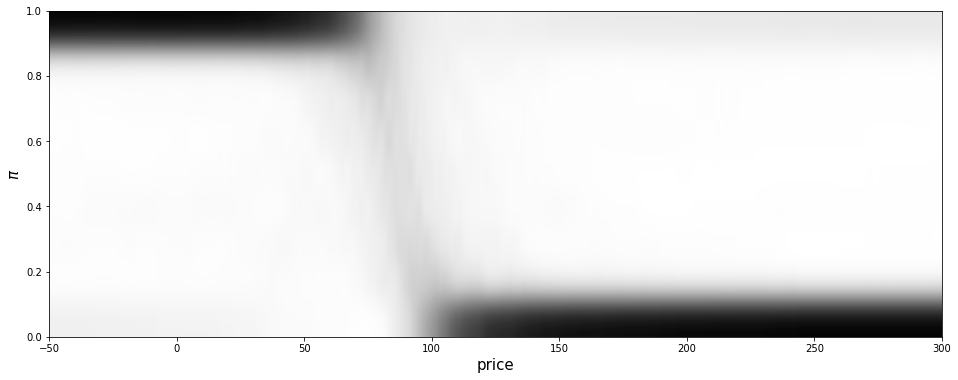

In [8]:
prices = np.arange(-50, 300)
bins = np.linspace(0, 1, 10, endpoint=True)
pis = bins[1:]
pdf = np.zeros((len(prices), len(pis)))
for p in range(len(prices)):
    hist, _ = np.histogram(buy_probability(prices[p]), bins=bins)
    pdf[p, :] = hist
X, Y = np.meshgrid(prices, pis)
fig, ax = plt.subplots(figsize=(16,6))
ax.imshow(pdf.transpose(), 
          interpolation='gaussian', 
          cmap=plt.cm.binary,
          aspect='auto', 
          origin='lower', 
          extent=(-50, 300, 0, 1), 
          vmax=pdf.max(), 
          vmin=0)
ax.set_ylabel(r"$\pi$", fontsize=15)
ax.set_xlabel(r"price", fontsize=15)

* Instead of the pdf we typically consider only point estimates (mean. interquartil distances etc) for visualization

* Furthermore, we can incorporate the utility function and find it's optimum

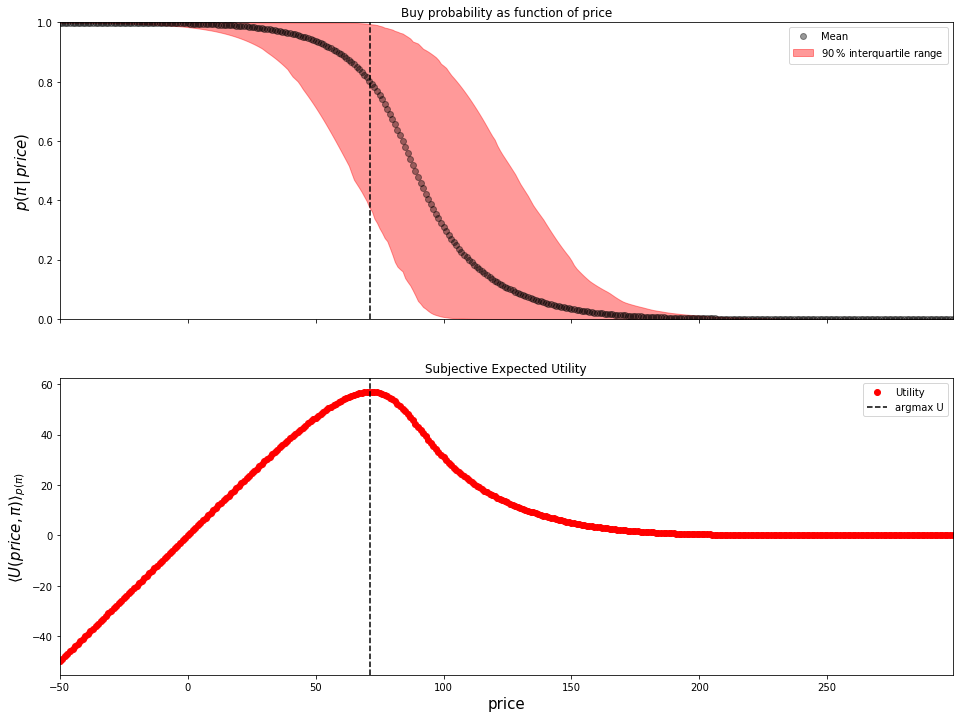

In [12]:
import numpy as np
prices = np.arange(-50, 300)[:,None]
probs = buy_probability(prices)
fig, ax = plt.subplots(nrows=2, figsize=(16,12), sharex=True)
ax[0].plot(prices, probs.mean(axis=1), 'o', color='black', alpha=0.4, label="Mean")
ax[0].fill_between(prices.flatten(), 
                np.percentile(probs, 5, axis=1), 
                np.percentile(probs, 95, axis=1), 
                color='red', 
                alpha=.4, 
                label=r"$90\,\%$ interquartile range")
ax[0].axvline(optimum, ls="--", color="black")
ax[0].set_ylabel(r"$p(\pi\,|\,price)$", fontsize=15)
ax[0].set_title("Buy probability as function of price")
ax[0].set_xlim(prices.min(), prices.max())
ax[0].set_ylim(0,1)
ax[0].legend()
ax[1].plot(prices, expected_utility(prices), "o", color="red", label="Utility")
ax[1].axvline(optimum, ls="--", color="black", label="argmax U")

ax[1].set_title("Subjective Expected Utility")
ax[1].set_ylabel(r"$\left \langle U(price, \pi)\right\rangle_{p(\pi)}$", fontsize=15)
ax[1].set_xlabel("price",  fontsize=15)
ax[1].legend();

#### Remark:
* Actually the definition of the utility function is not very intuitive!
* Alternatively one could set the utility as
%\text{price if bought and zero if not bought}

* $$
\begin{align}
U(price, bought) = 
\begin{cases}
price, ~ &\text{if } bought=1\\
0 , &\text{if } bought=0
\end{cases}
\end{align}
$$
* This eventually leads to the very same formula as we have seen it
* The expected Utility then reads
* $$U(price) = \sum_{bought} U(price, bought) p(bought | year, scratched)$$,
* where the sum goes over all states of bought (1=True, 0=False). Since for no buy the utility function is zero
this simplifies to
* $$U(price) = U(price, bought=1) p(bought=1\,|\,year, scratched)$$
* The conditional probability can be optained by Bayes Theorem or by sampling
* Note that we could also consider instead $p(bought)$. This would correspond to not caring about the state of the phone. It should give different results!

**TODO** 
* Work out difference between known states of phones to sell (year, scratched) vs unknown state of the phone
* Work out joint pdf vs conditional pdf in the probs

# Example 2: Shall I take the bus?
### The problem:
* Assume that you need to go to work. You could either take the bus right in front of your door, or take the bike. 
* The bus ride takes 10 mins, whereas you need 20 mins by bike.
* Since you are not a native early bird, you don't have any knowledge about the bus schedule - but you do have some data for bus waiting times (which you collected)
* Now, you need to decide if to wait for the bus or to take the bike. 
* Since we live in the new work era, assume that the time you spent for going to work just corresponds to the amount of money you would have earned (assuming that you earn 1 dollar per minute). The bus ride costs you 3 $ but riding your bike is free


### Utility function:
* Let's setup the Utility function, which depends on
* Decision $d$ (bike or bus)
* Waiting time on the bus stop $t$
$$
\begin{align}
U(d, t) = 
\begin{cases}
10 + 3 + t, ~ &\text{if } d=bus\\
20 , &\text{if } d=bike
\end{cases}
\end{align}
$$

### Expected Utility function
* We need to take the expectation value w.r.t $t$ of the Utility function:
$$U(d) = \int U(d, t) p(t)\,dt$$
* Assume that we have inferred a model from the data that depends on other RVs, say $\theta$ with joint pdf $p(t, \theta)$
* Thus, we need first marginalize out the other RVs - $p(t) = \int d\theta\, p(t, \theta)$ -  in order to compute the Expected Utility function
$$U(d) = \int dt\, \int d\theta \, U(d, t) p(t, \theta) $$
* **Alternatively we may rewrite** the joint as $p(t, \theta) = p(t\, |\,\theta) p(\theta)$ and arrive at the expression:
$$U(d) = \int d\theta \,  \int dt\, U(d, t) p(t\,|\,\theta) p(\theta)$$
So in this representation we would first compute the expected Utility function w.r.t the conditionals and then take the expectation value w.r.t to the (latent) $\theta$ variables.


* **Note:** with this setup we want to _minmize_ the expected utility function. 

### Influence diagram

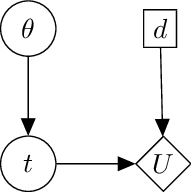

In [14]:
wimage(filename="./pics/influence_diagram_bus.pdf", resolution=200)

Where apart from the known circles that represent random variables, 
* the square indicates the decision $d$ to take
* the diamond indicates the utility function


In order to solve this influence diagram we need to set up the partial ordering 
$$d \prec t, \theta $$
Hence, there are no variables known prior to the decision and $d, t$ are not known prior to the decision or latent.

The expected Utility function is then given by (Eq. 7.3.1 in the Barber Book)
$$U(d) = \int d\theta \int dt \, p(t~|~\theta) p(\theta) U(d,t)$$

This is the same expression than above.
The optimal decision is the obtained by finding the minimum of the utility function,
$$argmin_d U (d)$$

### Data generating process
* Let's play god for a while and assume that the waiting time corresponds to an exponential distribution with expectation time of 4 mins

In [13]:
def generate_waiting_times(mean: float, size):
    return pd.DataFrame({'waiting_time': np.round(np.random.exponential(scale=mean, size=size))})

In [14]:
waiting_times = generate_waiting_times(10, 5)
waiting_times

,waiting_time
0,20.0
1,28.0
2,27.0
3,0.0
4,20.0


In [15]:
with pm.Model() as exponential_model:
    scale = pm.Uniform('scale', upper=30, lower=0, testval=6)
    waiting_time = pm.Exponential("waiting_time", 1/scale, observed=waiting_times.waiting_time)
    exponential_model_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [scale_interval__]
100%|██████████| 1000/1000 [00:00<00:00, 1461.21it/s]
The acceptance probability does not match the target. It is 0.9193373773946572, but should be close to 0.8. Try to increase the number of tuning steps.


#### Remark: 
* For this simple model we don't really need to perform MCMC computations
* Instead one could solve the problem analytically by using the Gamma distribution as conjugate prior to the exponential distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab0f046da0>,
      dtype=object)

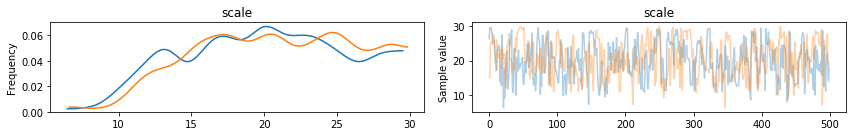

In [17]:
#inspect_model(exponential_model_trace)
pm.traceplot(exponential_model_trace)

In [19]:
def utility(decision, waiting_time):
    if decision == "bike":
        return 20 * np.ones(waiting_time.shape)
    if decision == "bus":
        return 10 + waiting_time + 3

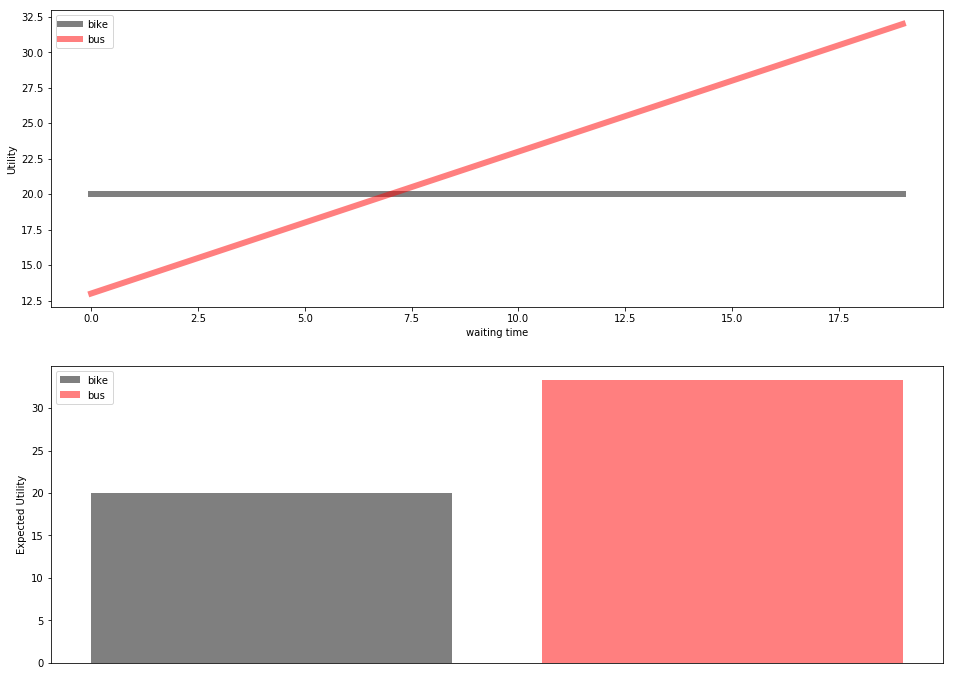

In [20]:
fig, ax = plt.subplots(nrows=2, figsize=(16,12))
ax[0].set_xlabel("waiting time")
ax[0].set_ylabel("Utility")
times = np.arange(20)
ax[0].plot(times, utility("bike", times), color="black", lw=6, alpha=.5, label="bike")
ax[0].plot(times,  utility("bus", times), color="red", lw=6, alpha=.5, label="bus")
ax[0].legend();
ax[1].set_ylabel("Expected Utility")
ax[1].bar(0,  utility("bike", np.ones(1)), color="black", alpha=0.5, label="bike")
ax[1].bar(1,  utility("bus", exponential_model_trace.scale).mean(), color="red", alpha=0.5, label="bus")
ax[1].legend()
ax[1].set_xticks([]);

### look at overall behavior
* Let's have a look on how the decision changes with increasing data with increasing data!

In [21]:
from collections import namedtuple
bus_ride = namedtuple("busride", ["data", "trace", "mean", "hpd_025", "hpd_975", "bus_utility"])

In [22]:
waiting_times = generate_waiting_times(6, 1000)

In [23]:
chunks = [waiting_times[:i] for i in [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 500, 1000]]
results = []

for chunk in chunks:
    with pm.Model() as exponential_model:
        scale = pm.Uniform('scale', upper=30, lower=0, testval=6)
        waiting_time = pm.Exponential("waiting_time", 1/scale, observed=chunk.waiting_time)
        traces = pm.sample(tune=1500, samples=3000)
    summary = pm.summary(traces).loc['scale']
    trace = traces["scale"]
    result = bus_ride(data=chunk,
                      trace = trace, 
                      mean = summary["mean"], 
                      hpd_025 = summary["hpd_2.5"],
                      hpd_975 = summary["hpd_97.5"],
                      bus_utility = utility("bus", trace).mean())
    results.append(result)
    

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [scale_interval__]
INFO:pymc3:NUTS: [scale_interval__]
100%|██████████| 2000/2000 [00:01<00:00, 1454.58it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chain

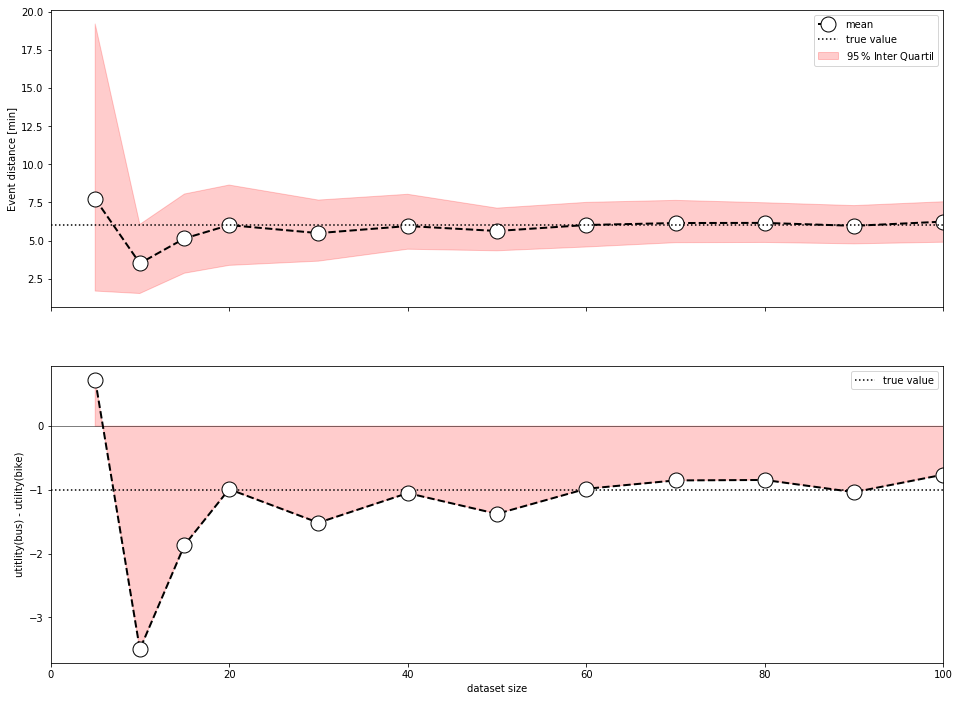

In [24]:
fig, ax = plt.subplots(nrows=2, figsize=(16,12), sharex=True)
datasize = list(map(lambda x: len(x.data), results))
mean = list(map(lambda x: x.mean, results))
hpd_low = list(map(lambda x: x.hpd_025, results))
hpd_high = list(map(lambda x: x.hpd_975, results))
bus_minus_bike_utility = list(map(lambda x: x.bus_utility - 20, results))
ax[0].plot(datasize, mean, 'o--', color='black', alpha=1, ms=15, lw=2, markerfacecolor="white", label="mean")
ax[0].fill_between(datasize, hpd_low, hpd_high, color="red", alpha=.2, label=r"$95\,\%$ Inter Quartil")
ax[0].axhline(6, color="black", ls=":", label="true value")
ax[0].set_xlim(0, 100)
ax[0].set_ylabel("Event distance [min]")
ax[0].legend()
ax[1].axhline(0, ls="-", lw=.5, color="black")
ax[1].axhline(-1, ls=":", color="black", label="true value")
ax[1].plot(datasize, bus_minus_bike_utility, "o--", color="black", lw=2, ms=15, markerfacecolor="white")
ax[1].fill_between(datasize, bus_minus_bike_utility, color="red", alpha=.2)
ax[1].set_ylabel("utitlity(bus) - utility(bike)")
ax[1].set_xlabel("dataset size")
ax[1].legend()



### Discussion


# Example 3: Fashion retailers

### The Problem
* Assume you are a fashion retailer and you want to give your customers hints about the product sizes in your webshop
* In particalar you want to give the hint "This T-Shirt is larger than average" if the product to too large and analgousely for too small products.
* So you want to decide whether or not to display this product hint


* We first consider the simplest approach by assuming that 
1. **If we make no size hint:** The costumer just order the piece in his intended size
2. **If we make a size hint:** The costumer will order two pieces of the same product, one in the originally intended size. The other one one size larger / smaller following our hint. 
3. The costumer will only keep one size. I.e., he will for sure return on of the two ordered pieces
 

### Utility function
* The decisions we can take is: no product hint (N), product hint "too small" (S),  and product hint "too large" (L)
* So our decision space is, $d=\{N, S, L\}$
* Now, we set up our utility function:
* **Case N:**
If we make no product hint we make 
$$
\begin{align}
U(d) = 
\begin{cases}
price, ~ &\text{if  not returned}\\
0 , &\text{if  return reason "too small"} \\ 
0 , &\text{if  return reason "too large"} \\ 
0 , &\text{if  return reason "other"}
\end{cases}
= 
\begin{cases}
price , ~ &\text{if  not returned}\\
0 , &\text{if  returned}
\end{cases}
= price (1 - returned)
\end{align}
$$
* **Case S:**
$$
\begin{align}
U(d) = 
\begin{cases}
price -\text{return cost}, ~ &\text{if original size is kept}\\
price -\text{return cost}, ~ &\text{if recommended size is kept (*)}\\
- 2 ~ \text{return cost} , &\text{if  return reason "too large"} \\ 
- 2 ~ \text{return cost} , &\text{if  return reason "other"}
\end{cases}
\end{align}
$$
* **Case L:**
$$
\begin{align}
U(d) = 
\begin{cases}
price -\text{return cost}, ~ &\text{if one size is kept}\\
price -\text{return cost}, ~ &\text{if recommended size is kept (**)}\\
- 2 ~ \text{return cost} , &\text{if  return reason "too small"} \\ 
- 2 ~ \text{return cost} , &\text{if  return reason "other"}
\end{cases}
\end{align}
$$

$(*)$ Return risk should decrease in this case because return reason too small is not allowed

$(**)$ Return risk should decrease in this case because return reason too large is not allowed


The factor of 2 comes from the situation, that the customer returns both sizes. This could arise by giving the wrong size hint, or, that the customer does not like the product at all.



In [96]:
t = pd.read_csv("resources/data_fashion_retailer.csv", 
                dtype={"returns_too_small":np.int64, "returns_too_large":np.int64})
t.dtypes

buys                  int64
returns               int64
returns_too_small     int64
returns_too_large     int64
product_id           object
dtype: object